In [ ]:
from google.colab import drive
from warnings import filterwarnings

drive.mount('/content/drive')
filterwarnings('ignore')

Mounted at /content/drive


На предыдущих занятиях мы преимущественно говорили об обработке обработке естественного языка в контексте обработки печатного текста. Однако "естественный язык" - более широкое понятие.

Сегодня немного поговорим об обработке речи (Speech-to-Text & Text-to-Speech), обработке изображений с текстовыми данными (OCR, Optical Character Recognition) и о семантическом поиске.

# STT, TTS

Speech to Text (STT или ASR - Automatic Speech Recognition) отвечает за преобразование речевого сигнала в текст.

Text to Speech (TTS) выполняет обратную задачу преобразования текста в речевой сигнал.

**Где используется?**

* Голосовые ассистенты (Алиса, Siri): STT используется для преобразования речевых команд в текст, а TTS позволяет ассистентам отвечать голосом

* Транскрибирование аудио, в том числе расшифровка голосовых сообщений и создание субтитров для видео

* Синхронный перевод

Нужно отметить, что отдельным направлением исследований является работа с жестовым языком. В отличие от работы с речью, которая представляет собой аудио, жестовый язык требует работы с изображениями и видеоматериалами.

**Как решается?**

* Синтез на основе готовых аудио (выдача готовых записей; составление из отрывков)

* Hidden Markov Models (HMM) - скрытые марковские модели для генерации последовательностей

* Глубокие нейронные сети

А что вообще такое звук и как его слышит компьютер?

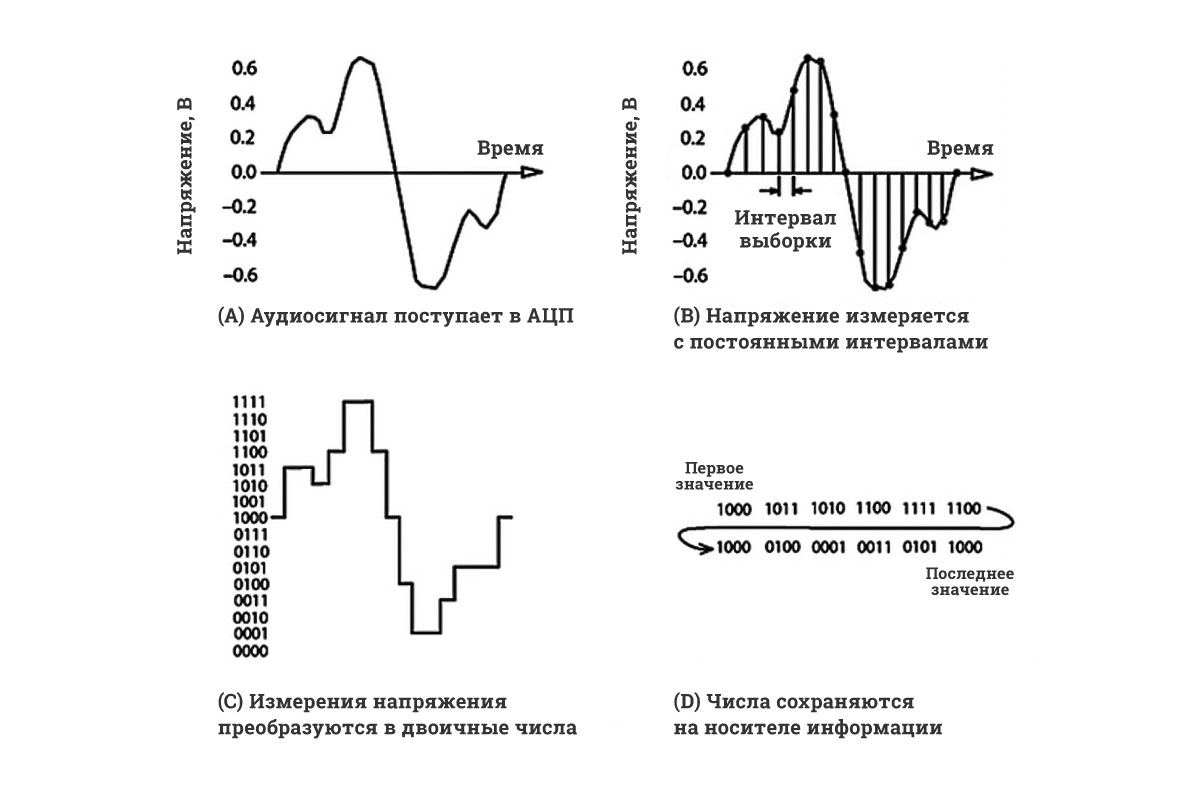

In [ ]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display


filename = librosa.ex('robin')  # скачаем файл
y, sr = librosa.load(filename)
ipd.Audio(filename)

In [ ]:
y  # цифровой сигнал

array([ 5.8678825e-06,  7.6058523e-06, -1.4612080e-05, ...,
       -5.2551704e-06, -1.0614921e-06,  2.8505165e-06], dtype=float32)

In [ ]:
sr  # частота дискретизации

22050

In [ ]:
librosa.get_duration(y=y, sr=sr)  # длительность аудио в секундах, len(y) / sr

2.698639455782313

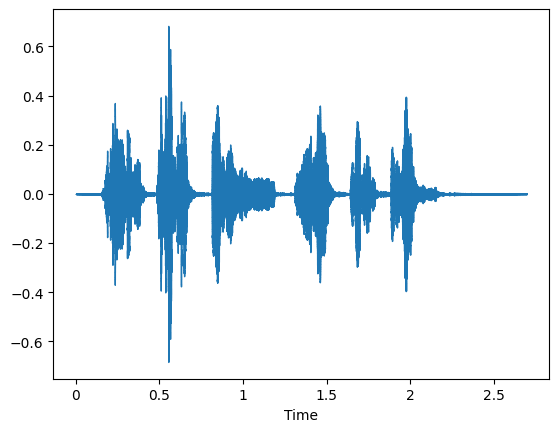

In [ ]:
librosa.display.waveshow(y=y, sr=sr)
plt.show()

То есть, звук - это последовательность чисел. Если мы научимся выделять в данной последовательности подпоследовательности, соответсвующие фонемам, мы научимся распознавать речь. Верно и обратное утверждение - если мы научимся генерировать верную последовательность чисел, мы получим речь.

Более подробно про работу со звуковым сигналом можно [прочитать здесь](https://bourabai.ru/signals/ts05.htm).

Посмотрим на пару готовых инструментов для работы с речью. Лучше всего с задачей справляются нейросети. Однако они потребляют много вычислительных ресурсов.

Важно отметить, что не стоит полностью отдавать обработку аудио на откуп нейросети. Если у вас в аудиозаписи присутствуют шумы, эхо и т.п. - имеет смысл провести предобработку, чтобы повысить качество распознавания.

В качестве данных возьмем аудиодорожку с ютуба.

In [ ]:
%%capture
!pip install pytube moviepy

In [ ]:
import pytube
import moviepy.editor as mp


def download_audio(youtube_url, output_path):
    yt = pytube.YouTube(youtube_url)
    audio_stream = yt.streams.filter(only_audio=True, file_extension="mp4").first()
    audio_stream.download(filename="temp_audio.mp4")
    audio_clip = mp.AudioFileClip("temp_audio.mp4")
    audio_clip.write_audiofile(output_path, codec="pcm_s16le")
    audio_clip.close()


youtube_url = "https://www.youtube.com/watch?v=DMQA0BhVDZk"
output_path = "youtube_file.wav"
download_audio(youtube_url, output_path)

MoviePy - Writing audio in youtube_file.wav


MoviePy - Done.


Функции для предобработки аудио.

In [ ]:
%%capture
!pip install wave pydub  # после загрузки нужно restart runtime

In [ ]:
from pydub import AudioSegment
import wave
import librosa


def get_wav_info(file_path):  # сводная информация по аудиофайлу
    with wave.open(file_path, "rb") as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        frame_rate = wf.getframerate()
        num_frames = wf.getnframes()
        duration = num_frames / float(frame_rate)
    audio_data, _ = librosa.load(file_path, sr=frame_rate)
    onset_env = librosa.onset.onset_strength(y=audio_data, sr=frame_rate)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=frame_rate)
    return {
        "File": file_path,
        "Channels": num_channels,
        "Sample Width (bytes)": sample_width,
        "Sample Rate (kHz)": frame_rate / 1000,
        "Duration (seconds)": duration,
        "Tempo (BPM)": tempo,
        "File Size (kB)": num_frames * num_channels * sample_width / 1024,
    }


def stereo_to_mono(input_file, output_file):
    audio = AudioSegment.from_file(input_file, format="wav")
    mono_audio = audio.set_channels(1)
    mono_audio.export(output_file, format="wav")

In [ ]:
get_wav_info("youtube_file.wav")

{'File': 'youtube_file.wav',
 'Channels': 2,
 'Sample Width (bytes)': 2,
 'Sample Rate (kHz)': 44.1,
 'Duration (seconds)': 254.4,
 'Tempo (BPM)': 126.04801829268293,
 'File Size (kB)': 43824.375}

### [AssemblyAI](https://www.assemblyai.com/)

Это сторонний API, дается 5 часов бесплатно каждый месяц. Как и большинство closed-source платных сервисов, работает прекрасно.

In [ ]:
%%capture
!pip install assemblyai

In [ ]:
import assemblyai as aai

aai.settings.api_key = " "  # your API key
config = aai.TranscriptionConfig(language_code="ru")
transcriber = aai.Transcriber(config=config)

In [ ]:
transcript = transcriber.transcribe("youtube_file.wav")
transcript.text

'Привет, на связи проект DevCalibri и мы продолжаем изучать систему контроля версии git и сегодня мы рассмотрим такую команду как commit и добавление файлов на commit-кандидат. Освежим немножко нашу память, как мы помним в прошлом видео мы сделали базовую конфигурацию, теперь у нас вот есть наш git-сэмпл, который является нашим проектом, также хочу сообщить о том, что Возможно, некоторые не знают, гид не привязан к какому-то определенному проекту в его структуре. Нам не обязательно использовать гид для Java проекта Ruby, либо Python, либо еще какого-то. Гид, в общем-то, работает со всеми практически видами файлов. Он плохо работает с бинарными файлами, такими как .exe, и тому подобное. Файлы, картинки, PDF-ки, видео. Вот с этим он работает плохо. Но со всем остальным он работает довольно удобно и круто. В основном это текстовые файлы. Сегодня мы попытаемся создать наш первый файл. Пускай это будет наш тест txt. И здесь мы напишем hello-git. После чего сохраним. Как видите, вот наш файл

### [NEMO](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/intro.html)

Аудио нужно привести в формат моно с расширением wav. На CPU аудио обрабатывается по времени примерно в два раза дольше, чем длина аудиофайла.

Всё последующее подружается в районе 7 минут.

In [ ]:
%%capture
!pip install nemo_toolkit['all']

In [ ]:
# это на случай, если какие-то несовместимости с cuda вылезать будут
%%capture
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [ ]:
%%capture
import nemo.collections.asr as nemo_asr

ASR_MODEL = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained("nvidia/stt_ru_conformer_transducer_large")

In [ ]:
get_wav_info("youtube_file.wav")

{'File': 'youtube_file.wav',
 'Channels': 2,
 'Sample Width (bytes)': 2,
 'Sample Rate (kHz)': 44.1,
 'Duration (seconds)': 254.4,
 'Tempo (BPM)': 126.04801829268293,
 'File Size (kB)': 43824.375}

In [ ]:
stereo_to_mono("youtube_file.wav", "youtube_file_mono.wav")  # для данной модели NEMO нужен моно формат
get_wav_info("youtube_file_mono.wav")

{'File': 'youtube_file_mono.wav',
 'Channels': 1,
 'Sample Width (bytes)': 2,
 'Sample Rate (kHz)': 44.1,
 'Duration (seconds)': 254.4,
 'Tempo (BPM)': 126.04801829268293,
 'File Size (kB)': 21912.1875}

In [ ]:
transcription = ASR_MODEL.transcribe(["youtube_file_mono.wav"])[0]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
transcription[0]

'привет на связи проект в колибре и мы продолжаем изучать систему контроля версии гид и сегодня мы рассмотрим такую команду как комитет и добавление файлов на комит кандидат а свяжим немножко нашу память как мы помним в прошлом виде мы сделали базовую конфигурацию и теперь у нас вот есть наш гитл который является нашим проектом также хочу сообщить о том что некоторые не знают гид не привязан к какому то определенному проекту и его структуре нам необязательно использует гид для джава проекта рубе либо питон либо еще какого то гид в общем то работает со всеми практически видами файлов он плохо работает с бинарными файлами и такими как экзе и тому подобное файлы картинки подкие видео вот с этим он работает плохо но со всем остальным он работает довольно удобно и круто в основном это текстовые файлы сегодня мы попытаемся создать наш первый файл он пускай это будет наш тест тексти и здесь мы напишем хэллоу гид после чего сохраним кивите вот наш файл открыли его мы увидим что вот наш хэллоуг

### [Whisper](https://openai.com/research/whisper)

In [ ]:
%%capture
!pip install git+https://github.com/openai/whisper.git

In [ ]:
import torch
import whisper


model_size = "small"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
WHISPER_MODEL = whisper.load_model(model_size)
WHISPER_MODEL.to(DEVICE)

100%|████████████████████████████████████████| 461M/461M [00:03<00:00, 146MiB/s]


Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=False)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
        (attn_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (mlp_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): Mult

In [ ]:
transcription = WHISPER_MODEL.transcribe("youtube_file.wav", language="ru", verbose=False)

100%|██████████| 25440/25440 [05:00<00:00, 84.78frames/s]


In [ ]:
transcription['text']

" Привет, на связи проект DevKalibria и мы продолжаем изучать систему контроля версии Git и сегодня мы рассмотрим такую команду как коммит и добавление файлов на коммит-кондидат. А свежим немножко нашу память, как мы помним в прошлом видео мы сделали базовую конфигурацию, теперь у нас вот есть наш Git-сампл, который является нашим проектом. Также хочу сообщить о том, что, возможно, некоторые не знают, Git не привязана к какому-то определенному проекту его структуры, нам не обязательно использовать Git для Java проекта Ruby либо Python либо еще какого-то. Git, в общем-то, работает со всеми практически видами файлов. Он плохо работает с бинарными файлами, такими как Xe и тому подобное, файлы, картинки, PDF-ки, видео, вот с этим он работает плохо. Но совсем остальным он работает довольно удобно и круто. Основом это текстового файла. Сегодня мы попытаемся создать наш первый файл, он пускает и это будет наш тест TXT, и здесь мы напишем HelloGit, после чего сохраним. Как видите, вот наш файл

### Немного деплоя

Здесь мы используем gradio. Помимо gradio, очень распространенным фреймворком для быстрого создания веб-интерфейса для ML-модели является [Streamlit](https://streamlit.io/).

In [ ]:
%%capture
!pip install gradio  # после загрузки нужно restart runtime

Возьмем NEMO, так как whisper достаточно долго работает на CPU.

In [ ]:
import os
import gradio as gr


def transcribe(audio_path):
    wav_info = get_wav_info(audio_path)

    if wav_info['Channels'] == 2:
        stereo_to_mono(audio_path, audio_path)
    text = ASR_MODEL.transcribe([audio_path])[0]

    return text[0]


gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(sources="microphone",
                    type="filepath"),
    outputs="text").launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c1ec283aec56f12533.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://c1ec283aec56f12533.gradio.live


Стриминговый формат.

In [ ]:
def transcribe(audio, state=""):
    text = ASR_MODEL.transcribe([audio])[0][0]
    state += text + " "
    print(text)  # это видно только при debug=True, но можно настроить запись в файл
    return state, state


gr.Interface(
    fn=transcribe,
    inputs=[
        gr.Audio(sources="microphone", type="filepath", streaming=True),
        "state"
    ],
    outputs=[
        "textbox",
        "state"
    ],
    live=True).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3a0a36e3da0bd8cd2c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[Туториал](https://www.kaggle.com/code/janesser777/simple-audio-recognition-recognizing-keywords) на тему, как создать собственный распознаватель речи с помощью нейросетевых методов.

Некоторые датасеты с записью речи:

* https://github.com/snakers4/open_stt
* https://commonvoice.mozilla.org/en/datasets
* https://github.com/sberdevices/golos


[Chrome расширение для записи звука](https://chrome.google.com/webstore/detail/smart-audio-capture/lfohcapleakcfmajfdeomgobhecliepj?hl=it) (если захотите записать свой голос)

### [TTS vosk](https://github.com/alphacep/vosk-tts)

Обратной задачей распознавания речи является её синтез.

In [ ]:
%%capture
!pip3 install vosk-tts

In [ ]:
from vosk_tts import Model, Synth

model = Model(model_name="vosk-model-tts-ru-0.4-multi")
synth = Synth(model)

# строчки из стихотворения Ёсими
poem = """
Говори со мной, брат. Пожалуйста, говори.
Ты найдешь меня там, в подсолнухах, как всегда.
"""

synth.synth(poem, "out.wav", speaker_id=2)

vosk-model-tts-ru-0.4-multi.zip: 100%|██████████| 128M/128M [00:10<00:00, 12.4MB/s]


In [ ]:
ipd.Audio("out.wav")

Существует также отдельная задача клонирования или переноса - своеобразный deepfake для речи. Это когда на основании существующих записей речи какого-то человека генерируется речь с таким же тоном, тембром и т.п.

# OCR

OCR (Optical Character Recognition) - задача распознавания текста, присутствующего на изображении. Существует большое количество ПО, позволяющего решать данную задачу. Посмотрим пару библиотек для Python.

### pytesseract

In [ ]:
%%capture
!sudo apt install tesseract-ocr
!pip install pytesseract

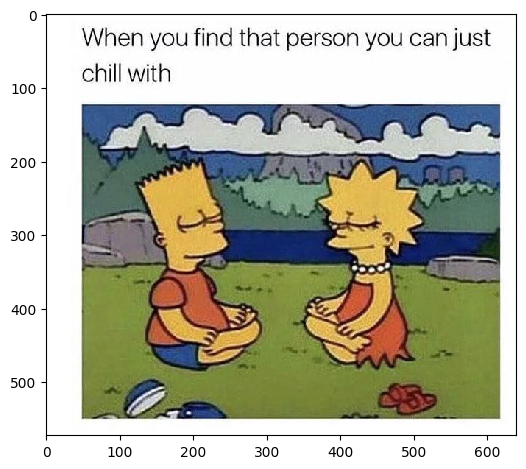

Extracted text: 
When you find that person you can just
chill with

 



In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pytesseract


img = imread("/content/drive/MyDrive/Work/NLP 23 24/data/images/eng.jpg")
imshow(img)
plt.show()

print("Extracted text: ")
text = pytesseract.image_to_string(img, lang="eng")
print(text)

In [ ]:
%%capture
!sudo apt-get install tesseract-ocr-rus  # для русского нужно отдельно скачать необходимые данные

In [ ]:
pytesseract.get_languages()  # по умолчанию поддерживается только английский

['eng', 'osd', 'rus']

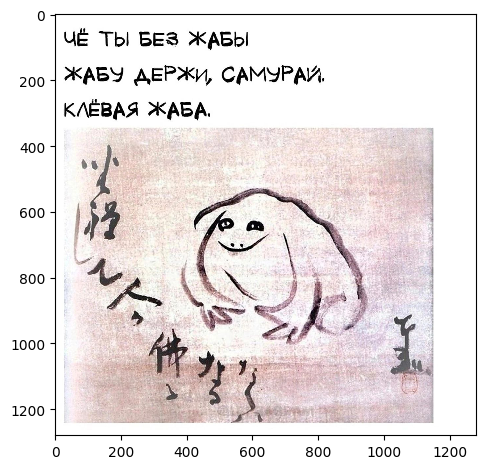

Extracted text: 
ЦЕ ТЫ БЕЗ ЖАБЫ
ЖАБУ ДЕРЖИ, САМУРАЙ.
КЛЁВАЯ ЖАБА.

 



In [ ]:
img = imread("/content/drive/MyDrive/Work/NLP 23 24/data/images/rus.jpg")
imshow(img)
plt.show()

print("Extracted text: ")
text = pytesseract.image_to_string(img, lang="rus")
print(text)

### easyOCR

In [ ]:
%%capture
!pip install easyocr

In [ ]:
import easyocr

reader = easyocr.Reader(['ru'], gpu=False)  # список языков, которые мы хотим распознать

Progress: |██████████████████████████████████████████████████| 100.1% Complete

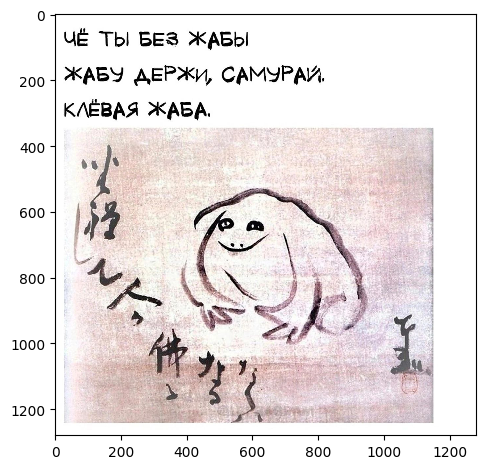

In [ ]:
img = imread('/content/drive/MyDrive/Work/NLP 23 24/data/images/rus.jpg')
imshow(img)
plt.show()

In [ ]:
result = reader.readtext('/content/drive/MyDrive/Work/NLP 23 24/data/images/rus.jpg', detail=0)  # detail ~ verbose
result

['ЧЁ',
 'ТЫ БЕз ЖАБЫ',
 'ЖАБУ АЕРЖИ САМУРАИ;',
 'КАЁВАЯ ЖАБА;',
 ';',
 '"?',
 "К* %'"]

Выглядит очень хорошо.

# Search

Задача поиска релевантной информации по запросу очень актуальна на сегодняшний день. Есть различные подходы к решению данной задачи.

Можно искать полное или частичное (fuzzy-search) совпадение строк, однако данный подход подходит только для данных, хранящихся в словарной структуре.

Можно использовать семантический поиск. В прошлый раз мы разбирали понятие векторизации - если построить для каждого текста смысловой вектор, а затем искать наиболее похожие на него вектора, можно получить релевантный ответ на заданный вопрос.

Можно применить подход из рекомендательных систем - если пользователи отмечают определенный ответ на запрос как хороший, наверное он действительно хороший, и стоит выдавать его в качестве ответа.


Для ускорения поиска используется индексация. Использование индексов позволяет вам получать ответ на запрос гораздо быстрее, чем за полный пробег по базе данных. Рассмотрим одну из наиболее популярных библиотек для индексации.

### [faiss](https://github.com/facebookresearch/faiss)

В качестве данных возьмем определения различных терминов с Википедии.

In [ ]:
%%capture
!pip install wikipedia

In [ ]:
import wikipedia

wikipedia.set_lang("ru")


wikipedia.summary("Natural Language Processing", sentences=3)

'Обработка текстов на естественном языке (Natural Language Processing, NLP) — общее направление искусственного интеллекта и математической лингвистики. Оно изучает проблемы компьютерного анализа и синтеза текстов на естественных языках. Применительно к искусственному интеллекту анализ означает понимание языка, а синтез — генерацию грамотного текста.'

In [ ]:
import pandas as pd


df_terms_description = pd.read_csv('/content/drive/MyDrive/Work/NLP 23 24/data/terms_descriptions_overall.csv')
df_terms_description.sample(5)

,term,description
2619,WebXR,WebVR — это экспериментальный браузерный API д...
6317,Смешанная реальность,"Сме́шанная реа́льность (англ. Mixed reality, M..."
6187,Apache Cassandra,Apache Cassandra — распределённая система упра...
265,Роевой интеллект,Роевой интеллект (РИ) (англ. swarm intelligenc...
571,Покрытие кода,"Покры́тие ко́да — мера, используемая при тести..."


In [ ]:
len(df_terms_description)

10530

Данный код использовался для создания файла с данными. Вы можете использовать его в своих проектах, если хотите.

In [ ]:
import csv
import wikipedia
from queue import Queue


wikipedia.set_lang("ru")


def update_csv(file_path, new_term, new_description):
    with open(file_path, 'a', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['term', 'description']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({'term': new_term, 'description': new_description})


if __name__ == '__main__':

    with open('pages_titles_list.txt', 'r', encoding='utf-8') as file:
        pages_titles = eval(file.read())

    csv_file_path = 'wiki_terms_descriptions.csv'

    # Initial CSV file creation with headers
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['term', 'description']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    not_visited_pages = Queue()
    for page_title in pages_titles:
        not_visited_pages.put(page_title)

    visited_pages = set()
    n_really_visited_pages = 0
    MAX_PAGES = 1_000_000

    # Set the desired length for the summary (in characters)
    MAX_SUMMARY_LENGTH = 500

    while len(visited_pages) < MAX_PAGES and not_visited_pages.qsize() > 0:
        if n_really_visited_pages % 10 == 0:
            print(n_really_visited_pages)

        current_page_title = not_visited_pages.get()

        try:
            # Get a summary with a maximum length of MAX_SUMMARY_LENGTH characters
            page_summary = wikipedia.summary(current_page_title, auto_suggest=False)
            if len(page_summary) > MAX_SUMMARY_LENGTH:
              page_summary = wikipedia.summary(current_page_title, auto_suggest=False, sentences=5)

            # Get the links for potential new pages
            page_links = wikipedia.page(current_page_title, auto_suggest=False).links
            new_pages_set = set(page_links)

            # Extend the queue with new pages
            not_visited_pages.queue.extend(new_pages_set - visited_pages)
            visited_pages.add(current_page_title)

            new_term, new_description = current_page_title, page_summary
            update_csv(csv_file_path, new_term, new_description)

            n_really_visited_pages += 1

        except Exception as e:
            print(f"Error processing {current_page_title}: {e}")
            pass

Построим эмбеддинги для нашей базы с помощью трансформера, обученного на русскоязычных данных.

In [ ]:
%%capture
!pip install faiss-cpu transformers sentence_transformers sentencepiece

In [ ]:
import faiss
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('cointegrated/rubert-tiny2')
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

.gitignore:   0%|          | 0.00/6.00 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/118M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tinybert-ru-labse-adapter-v2.pt:   0%|          | 0.00/963k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(df_terms_description['term'].tolist())

Создадим индекс для быстрого поиска.

In [ ]:
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings.astype(np.float32))

Выглядит неплохо.

In [ ]:
%%time
query_term = "Кого кудрячит глокая куздра?"

query_vector = model.encode([query_term]).flatten()
query_vector /= np.linalg.norm(query_vector)
k = 3
distances, neighbors = index.search(np.array([query_vector], dtype=np.float32), k)

similar_neighbors = [df_terms_description.iloc[idx] for idx in neighbors.flatten()]
pd.DataFrame(similar_neighbors)

CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 20.6 ms


,term,description
2842,Баннерная слепота,"Баннерная слепота — феномен в веб-юзабилити, п..."
8157,Никомах Герасский,"Никома́х из Гера́сы, Никома́х Гера́сский (др.-..."
4313,Гаджет,"Га́джет (англ. gadget — приспособление, устрой..."


Хотя достаточно часто мы будем получать странные результаты. Как думаете, с чем это может быть связано?

In [ ]:
query_term = "nlp"

query_vector = model.encode([query_term]).flatten()
query_vector /= np.linalg.norm(query_vector)
k = 3
distances, neighbors = index.search(np.array([query_vector], dtype=np.float32), k)

similar_neighbors = [df_terms_description.iloc[idx] for idx in neighbors.flatten()]
pd.DataFrame(similar_neighbors)

,term,description
9260,nltk,NLTK - кросс-платформенная библиотека для рабо...
8460,tcp,Transmission Control Protocol (TCP) — протокол...
8674,udp,UDP (User Datagram Protocol — протокол пользов...


# Задание

Найдите информацию о какой-либо задаче, связанной с обработкой естественного языка. Кратко (5-10 предложений) опишите, в чём она состоит.

Например:

**Задача разрешения кореференции** заключается в определении, какие слова или фразы в тексте относятся к одному и тому же объекту или лицу, а также определении типа связи между ними (какие упоминания являются местоименными, какие именными и т.д). Предположим, у нас есть предложение: "Миша пошел в магазин. Он купил сыр. Но тот оказался невкусным." В данном случае, "он" относится к "Мишу", а "тот" относится к "сыру".

В качестве источника информации можно использовать материалы конференций, например [Dialogue](https://www.dialog-21.ru/) или [AINL](https://ainlconf.ru/).